In [1]:
import os
import time
import pandas as pd
import numpy as np
import datetime
import pymysql
from sqlalchemy import create_engine
import FinanceDataReader as fdr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf
import warnings
warnings.filterwarnings('ignore')

# make_train_data

In [3]:
lst_code=[]
IF = open("code_list.txt", 'r')
for line in IF:
    code = line.strip('\n').split('\t')
    lst_code.append(code[0])
    
IF.close()

db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = 'stock_user', 
    passwd = 'bigdata', 
    db = 'refined_stock', 
    charset = 'utf8'
)
cursor = db_dsml.cursor()

result = []

for code in tqdm(lst_code):
    sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date
                    BETWEEN '2017-11-01' AND '2020-12-31'
                    '''.format(code)
    
    stock = pd.read_sql(sql=sql_query, con=db_dsml)
    date_list = stock['Date']
    next_change_list = stock['Next Change']
    stock['trading_value'] = stock['Close'] * stock['Volume']
    
    stock = stock[['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
                   'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
                   'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD', # scaling 필요 정보 24개
       'Volume','trading_value',
       'MFI', 'ADI', 'OBV',
       'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
       'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
       'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
       'WR', 'AO', 'ROC', 'PPO', 'PVO']]
    lst_stock=stock.values.tolist()

    
    # 스케일링
    scaled_stock_list=[]
    for i , row in enumerate(lst_stock):
        prev_close = lst_stock[i-1][3]
        
        scaled_inform=[]
        non_scaled_inform = row[24:]
        
        for value in row[:24]:
            scaled_inform.append( value / prev_close )
        
        scaled_stock_list.append(scaled_inform + non_scaled_inform)
    
        # 10일치 만들기
        
    for ii, (row2, date, next_change) in enumerate(zip(scaled_stock_list, date_list, next_change_list)):
        
        if (ii < 9) and next_change == None :
            continue
    
        if date <= pd.to_datetime('2018-01-01'):
            continue
            
        High, Low, MA20, trading_value = row2[1], row2[2], row2[5], row2[25]
#         next_change = int(next_change >= 0.05)
        
        if High >= MA20 >= Low and trading_value >= 1000000000 :
            data_10_days = scaled_stock_list[ii-9:ii+1]
            day_10 = [date, code]

            for rows in data_10_days:
                day_10 += rows
            day_10 += [next_change]   
            result.append(day_10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [02:40<00:00,  9.70it/s]


In [4]:
np.save('/project/dsml2022/gksmf457/team_project/4th_scaled_trainset_compare_ma20.npy', result)

# make_test_data

In [5]:
lst_code=[]
IF = open("code_list.txt", 'r')
for line in IF:
    code = line.strip('\n').split('\t')
    lst_code.append(code[0])
    
IF.close()

db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = 'stock_user', 
    passwd = 'bigdata', 
    db = 'refined_stock', 
    charset = 'utf8'
)
cursor = db_dsml.cursor()

result = []

for code in tqdm(lst_code):
    sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date
                    BETWEEN '2020-11-01' AND '2021-12-31'
                    '''.format(code)
    
    stock = pd.read_sql(sql=sql_query, con=db_dsml)
    date_list = stock['Date']
    next_change_list = stock['Next Change']
    stock['trading_value'] = stock['Close'] * stock['Volume']
    
    stock = stock[['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
                   'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
                   'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD', # scaling 필요 정보 24개
       'Volume','trading_value',
       'MFI', 'ADI', 'OBV',
       'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
       'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
       'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
       'WR', 'AO', 'ROC', 'PPO', 'PVO']]
    lst_stock=stock.values.tolist()

    
    # 스케일링
    scaled_stock_list=[]
    for i , row in enumerate(lst_stock):
        prev_close = lst_stock[i-1][3]
        scaled_inform=[]
        non_scaled_inform = row[24:]
        
        for value in row[:24]:
            scaled_inform.append( value / prev_close )
        
        scaled_stock_list.append(scaled_inform + non_scaled_inform)
    
        # 10일치 만들기
        
    for ii, (row2, date, next_change) in enumerate(zip(scaled_stock_list, date_list, next_change_list)):
        
        if (ii < 9) and next_change == None :
            continue
    
        if date <= pd.to_datetime('2021-01-01'):
            continue
            
        High, Low, MA20, trading_value = row2[1], row2[2], row2[5], row2[25]
#         next_change = int(next_change >= 0.05)
        
        if High >= MA20 >= Low and trading_value >= 1000000000 :
            data_10_days = scaled_stock_list[ii-9:ii+1]
            day_10 = [date, code]

            for rows in data_10_days:
                day_10 += rows
            day_10 += [next_change]   
            result.append(day_10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [01:05<00:00, 23.91it/s]


In [6]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,543,544,545,546,547,548,549,550,551,552
0,2021-01-25,050120,1.001724,1.005172,0.981034,0.982759,1.009310,1.011724,1.004770,1.135474,...,0.000000,-17.597028,31.639201,6.521739,-93.478261,-276.441176,-10.321489,-1.752051,-24.747406,-0.020755
1,2021-05-06,050120,1.009074,1.012704,0.992740,1.005445,0.987659,0.954764,0.852526,0.950144,...,0.530154,31.360197,57.144593,87.096774,-12.903226,387.632353,13.940520,4.262992,24.879968,0.003263
2,2021-05-17,050120,1.000000,1.073345,0.992844,1.048301,1.040787,0.987835,0.868724,0.935502,...,0.231733,22.795831,44.167009,53.043478,-46.956522,424.411765,0.336700,3.317462,14.449253,0.006711
3,2021-06-18,050120,1.015625,1.034091,0.998580,1.004261,0.994034,0.916761,0.808026,0.761701,...,0.000000,34.682767,63.567509,65.151515,-34.848485,579.205882,2.173913,4.104092,-11.476878,-0.032624
4,2021-06-21,050120,1.012730,1.015559,0.947666,0.971711,0.989816,0.917327,0.810573,0.759105,...,0.000000,30.666796,54.922817,20.689655,-79.310345,508.382353,-4.078762,3.573962,-9.334496,-0.023460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56056,2021-04-19,000540,1.003807,1.038071,0.989848,1.015228,1.017513,1.009772,0.934243,0.829537,...,0.325492,6.860907,45.580924,27.272727,-72.727273,5.382353,-0.618047,0.882663,-34.534543,0.298507
56057,2021-05-17,000540,1.000000,1.042506,0.988814,1.032438,1.021477,0.986633,0.902964,0.789066,...,0.000000,16.261674,41.644995,24.657534,-75.342466,391.426471,2.564103,3.085553,-6.817865,0.011957
56058,2021-06-23,000540,1.000000,1.002123,0.985138,0.986200,0.999788,0.980679,0.938075,0.830547,...,0.403115,-2.023026,31.550847,21.383648,-78.616352,-31.882353,-2.038627,-0.255995,32.424438,-0.008762
56059,2021-06-28,000540,1.003308,1.004410,0.987872,1.002205,1.016538,1.013120,0.980081,0.871334,...,1.000000,0.186255,35.667152,41.509434,-58.490566,-14.926471,1.722282,0.037720,13.677568,-0.016931


In [7]:
np.save('/project/dsml2022/gksmf457/team_project/4th_scaled_testset_compare_ma20.npy', result)


# learning

In [249]:
import numpy as np
import sklearn.metrics as metrics
import pickle
from xgboost import XGBRegressor # 회귀트리 모델
import xgboost as xgb

train = np.load('../team_project/4th_scaled_trainset_bollinger.npy',allow_pickle=True)

trainX=[]
trainY=[]
for row in train:
    trainX.append(row[2:-1])
    trainY.append(row[-1])
    
trainX=np.array(trainX)
trainY=np.array(trainY)

    
import numpy as np

test = np.load('../team_project/4th_scaled_testset_bollinger.npy',allow_pickle=True)


testX=[]
testY=[]
for row in test:
    testX.append(row[2:-1])
    testY.append(row[-1])
    
testX=np.array(testX)
testY=np.array(testY)



print(trainX.shape, testX.shape)

(117943, 550) (56061, 550)


# modelling

In [250]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import roc_curve

def plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    fpr, tpr, thresholds = roc_curve(testY, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_f1 = f1_score(trainY, train_pred)
    test_f1 = f1_score(testY, test_pred)
    
    train_recall = recall_score(trainY, train_pred)
    test_recall = recall_score(testY, test_pred)
    
    train_pre = precision_score(trainY, train_pred)
    test_pre = precision_score(testY, test_pred)  
    
    train_acc = accuracy_score(trainY, train_pred)
    test_acc = accuracy_score(testY, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=16)
    plt.legend()
    plt.show()
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

def get_clf_eval(testY, y_pred_test):
    confusion = confusion_matrix(testY, y_pred_test)
    accuracy = accuracy_score(testY, y_pred_test)
    precision = precision_score(testY, y_pred_test)
    recall = recall_score(testY, y_pred_test)
    F1 = f1_score(testY, y_pred_test)
    AUC = roc_auc_score(testY, y_pred_test)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))
    
    
    
    



[5]	valid_0's auc: 0.664197	valid_0's binary_logloss: 0.593297
[10]	valid_0's auc: 0.671568	valid_0's binary_logloss: 0.539025
[15]	valid_0's auc: 0.67547	valid_0's binary_logloss: 0.509341
[20]	valid_0's auc: 0.676838	valid_0's binary_logloss: 0.490492
[25]	valid_0's auc: 0.677904	valid_0's binary_logloss: 0.477843
[30]	valid_0's auc: 0.679578	valid_0's binary_logloss: 0.468888
[35]	valid_0's auc: 0.680418	valid_0's binary_logloss: 0.46337
[40]	valid_0's auc: 0.680884	valid_0's binary_logloss: 0.458086
[45]	valid_0's auc: 0.681742	valid_0's binary_logloss: 0.453462
[50]	valid_0's auc: 0.682146	valid_0's binary_logloss: 0.450143
[55]	valid_0's auc: 0.681471	valid_0's binary_logloss: 0.447554
[60]	valid_0's auc: 0.681243	valid_0's binary_logloss: 0.445712
[65]	valid_0's auc: 0.681185	valid_0's binary_logloss: 0.443537
[70]	valid_0's auc: 0.681482	valid_0's binary_logloss: 0.441773
[75]	valid_0's auc: 0.681105	valid_0's binary_logloss: 0.439419


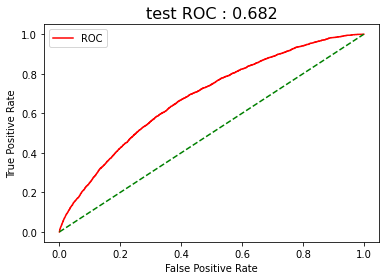

train_f1 score:  0.2417067166803423
test_f1 score:  0.16203485633537446 

train_recall score:  0.41021220159151195
test_recall score:  0.23521367521367523 

train_pre score:  0.17132886500858582
test_pre score:  0.12358541404706305 

train acc score:  0.8354544144205251
test acc score:  0.8730668379087065 

오차행렬:
 [[48257  4879]
 [ 2237   688]]

정확도: 0.8731
정밀도: 0.1236
재현율: 0.2352
F1: 0.1620
AUC: 0.5717


In [298]:
from lightgbm import LGBMClassifier
import os
import time

start_time=time.time()

model = LGBMClassifier(
                       scale_pos_weight=10,
                       learning_rate=0.1, 
                       num_iterations = 1000, # n_estimator 랑 같은 것 같음
                       max_depth =4,
                       n_jobs=30,
                       boost_from_average=False)

trained_model = model.fit( trainX, trainY, 
          eval_set=[(testX,testY)],
          early_stopping_rounds=30, 
          verbose = 5, 
          eval_metric = 'auc')

train_pred_20 = trained_model.predict(trainX)
train_prob_20 = trained_model.predict_proba(trainX)[:, 1]

test_pred_20 = trained_model.predict(testX)
test_prob_20 = trained_model.predict_proba(testX)[:, 1]

plot_roc_curve(trainY, testY, train_pred_20, test_pred_20, train_prob_20, test_prob_20)
get_clf_eval(testY, test_pred_20)


In [291]:
pd.DataFrame(testY).value_counts()

0    53136
1     2925
dtype: int64

In [99]:
TP=[]
FP=[]
TN=[]
FN=[]
for prob, pred, label in zip(test_prob_20, test_pred_20, testY):
    if pred == 1 and label ==1:
        TP.append(prob)
    elif pred == 0 and label ==1:
        FP.append(prob)
    elif pred == 0 and label ==0:
        TN.append(prob)
    elif pred == 1 and label ==0:
        FN.append(prob)

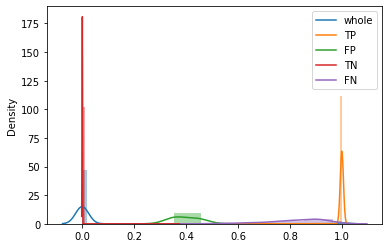

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
# fig = plt.figure(figsize(10,10))

sns.distplot(test_prob_20)
sns.distplot(TP)
sns.distplot(FP)
sns.distplot(TN)
sns.distplot(FN)
plt.legend(labels = ['whole', 'TP', 'FP', 'TN','FN'])

In [101]:
len(np.array(test_prob_20))

56060

In [102]:
sum(np.array(TP)>0.8)

2896

In [103]:
sum(np.array(FN)>0.8)

55